### Финальный проект

- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар > 7 долларов**
- **Все товары из разных категорий** (категория - sub_commodity_desc)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
module_path = os.path.abspath(os.path.join(os.curdir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import money_precision_at_k, mean_money_precision_at_k, get_prices
from src.utils import prefilter_items, create_prices_df
from src.recommenders import MainRecommender

%load_ext autoreload
%autoreload

In [2]:
data = pd.read_csv('./raw_data/retail_train.csv')
item_features = pd.read_csv('./raw_data/product.csv')
user_features = pd.read_csv('./raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


In [3]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [4]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


### Разделение train-val

Чтобы корректно разделить датасеты посмотрим на public test

In [5]:
data_public_test = pd.read_csv('./raw_data/retail_test.csv')

In [6]:
data_public_test['week_no'].unique()

array([96, 97, 98])

В паблик тесте присутствуют данные за 3 недели. Сформируем для дальнейшего исследования аналогичный валидационный датасет

In [7]:
test_size_weeks = 3

In [8]:
data_train = data.loc[(data['week_no'] <= data['week_no'].max() - test_size_weeks)]
data_val = data.loc[(data['week_no'] > data['week_no'].max() - test_size_weeks)]

### Анализ для предфильтрации

**0. Транзакции с нулевой стоимостью и количеством**

В датасете присутствует достаточно много строк с транзакциями, у которых стоимость и количество купленного товара равно 0. Избавимся от этих строк.

In [9]:
train_idx_todrop = data_train.loc[(data_train['quantity'] == 0) & (data_train['sales_value'] <= 0.1)].index
test_idx_todrop = data_val.loc[(data_val['quantity'] == 0) & (data_val['sales_value'] <= 0.1)].index
data_train = data_train.drop(index=train_idx_todrop, axis=0).reset_index()
data_val = data_val.drop(index=test_idx_todrop, axis=0).reset_index()

In [10]:
data_train.loc[data_train['quantity'] == 0].head(2)

,index,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
634624,637766,2035,30217406304,226,866871,0,5.82,298,0.0,1342,33,0.0,0.0
942106,946650,1907,31502778568,304,866858,0,0.50,369,0.0,1544,44,0.0,0.0


Осталось некоторое количество строк с нулевым количеством, но ненулевой суммой покупки. Суммы достаточно низкие, поэтому заменим количество таких транзакций на 1

In [11]:
data_train.loc[data_train['quantity'] == 0, 'quantity'] = 1
data_val.loc[data_val['quantity'] == 0, 'quantity'] = 1

In [12]:
data_train.loc[data_train['sales_value'] == 0]

,index,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
761,766,2110,27009082349,3,837963,1,0.0,375,0.00,1547,1,0.0,0.0
991,996,568,27021090189,4,951412,1,0.0,446,-1.48,35,1,0.0,0.0
1089,1095,2110,27021248054,4,850115,1,0.0,375,-3.29,1705,1,0.0,0.0
1107,1113,2110,27021248054,4,976872,1,0.0,375,-2.49,1705,1,0.0,0.0
1155,1161,474,27021262361,4,940108,1,0.0,352,-1.19,2204,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295880,2308739,2343,41382912830,642,13910208,1,0.0,396,-6.99,1701,92,0.0,0.0
2296245,2309106,2345,41382953921,642,940207,1,0.0,450,-6.69,1708,92,0.0,0.0
2296839,2309702,232,41383029591,642,1122250,1,0.0,34280,-3.99,1417,92,0.0,0.0
2298243,2311114,22,41383302099,642,16769972,1,0.0,365,-4.95,1220,92,0.0,0.0


Также осталось некоторое количество транзакций с нулевой стоимостью. С ними никакую предобработку не совершаем, предполагаем, что это какие-либо акции или товары в подарок

**1. Определим, после какого периода товар можно считать устаревшим и не рекомендовать его**

In [13]:
# Все товары в тесте (валидационной выборке)
test_items = set(data_val['item_id'])

# Все товары в train
train_items = set(data_train['item_id'])

# Товары, которые есть в train, но нет в test
old_items = train_items.difference(test_items)

# Новые товары в тесте
new_items = test_items.difference(train_items)

print(f'Всего в датасете {len(train_items.union(test_items))} товаров')
print(f'Из них {len(old_items)} не появляются в test')
print(f'При этом в test {len(test_items)} товаров, из которых {len(new_items)} новых товаров')
print(f'Процент совершенно новых товаров составляет {len(new_items) / len(test_items) * 100:.2f}%')

Всего в датасете 88743 товаров
Из них 68178 не появляются в test
При этом в test 20565 товаров, из которых 1408 новых товаров
Процент совершенно новых товаров составляет 6.85%


In [14]:
intersection_percents = []
for i in range(data['week_no'].max() - test_size_weeks - 4):
    current_train_items = set(data.loc[
        (data['week_no'] <= data['week_no'].max() - test_size_weeks) &
        (data['week_no'] > data['week_no'].max() - test_size_weeks - 4 - i), 'item_id'])
    
    # Смотрим процент товаров пересекающихся с тестом
    intersection_percent = len(current_train_items.intersection(test_items)) / len(test_items) * 100
    intersection_percents.append(intersection_percent)

In [15]:
weeks_no = list(range(4, data['week_no'].max() - test_size_weeks))

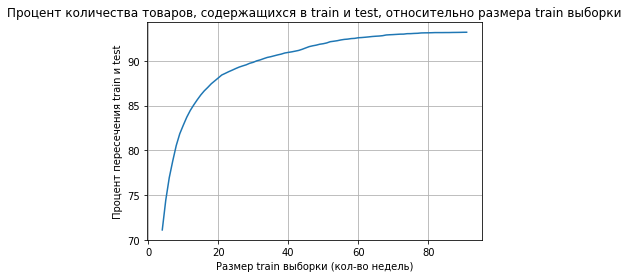

In [16]:
plt.plot(weeks_no, intersection_percents)
plt.title('Процент количества товаров, содержащихся в train и test, относительно размера train выборки')
plt.xlabel('Размер train выборки (кол-во недель)')
plt.ylabel('Процент пересечения train и test')
plt.grid()

Также стоит помнить, что в test содержится 7% новых товаров. <br>
То есть, отбросив, например, товары, которые не продавались более 20 недель, мы все равно покроем ~95% тестовой выборки, учитывая, 7% новых товаров

**1.2 Сколько уникальных товаров содержится в train выборке в зависимости от количества выбранных недель**

In [17]:
train_percents = []
for i in range(data['week_no'].max() - test_size_weeks - 4):
    current_train_items = set(data.loc[
        (data['week_no'] <= data['week_no'].max() - test_size_weeks) &
        (data['week_no'] > data['week_no'].max() - test_size_weeks - 4 - i), 'item_id'])
    
    # Смотрим процент товаров пересекающихся с тестом
    train_percent = len(current_train_items) / len(train_items) * 100
    train_percents.append(train_percent)

In [18]:
weeks_no = list(range(4, data['week_no'].max() - test_size_weeks))

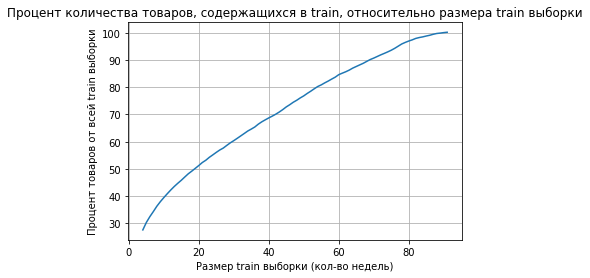

In [19]:
plt.plot(weeks_no, train_percents)
plt.title('Процент количества товаров, содержащихся в train, относительно размера train выборки')
plt.xlabel('Размер train выборки (кол-во недель)')
plt.ylabel('Процент товаров от всей train выборки')
plt.grid()

Здесь зависимость близка к линейной. Из графика видно, что отбросив товары старше 20 недель, мы сократим количество товаров, доступных для предсказаний, на ~50%. Т.е. с 90 000 до ~45 000, потеряв при этом всего около 5% ( ~1000) потенциально актуальных товаров (см ниже).

**1.3 Насколько популярны в тесте товары старше 20 недель**

Необходимо убедиться, что товары старше 20 недель по каким-либо причинам не попадают в верхушку топа в тесте. Для этого отсортируем товары из теста по популярности (популярность считаем по значению quantity) и посмотрим, какой рейтинг имеет самый популярный из старых товаров

In [20]:
def rate_filtered_items_on_test(filtered_list, test_items_top):
    """Функция для проверки популярности отфильтрованных товаров
    Input
    -----
    filtered_list: список отфильтрованных товаров
    test_items_top: список товаров из валидационной выборки, отсортированных по популярности
    
    Return
    ------
    items_rates: словарь, где ключи - id отфильтрованного товара, значения - место в топе товаров
    """
    items_rates = {item: test_items_top.index(item) for item in filtered_list}
    items_rates = {k: v for k, v in sorted(items_rates.items(), key=lambda item: item[1])}
    return items_rates

In [21]:
# Отсортированные по популярности товары в test
test_popularity = data_val.groupby('item_id')['quantity'].sum().reset_index()
test_popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
top_test = test_popularity.sort_values('n_sold', ascending=False).item_id.tolist()

In [22]:
# Товары старше 20 недель присуствующие в test
older_20_weeks = data_train.loc[(data_train['week_no'] <= data_train['week_no'].max() - 20), 'item_id'].tolist()
younger_20_weeks = data_train.loc[(data_train['week_no'] > data_train['week_no'].max() - 20), 'item_id'].tolist()

older_20_weeks_only = set(older_20_weeks).difference(set(younger_20_weeks))
older_20_weeks_in_test = list(set(older_20_weeks_only).intersection(set(top_test)))

older_20_weeks_items_rates = rate_filtered_items_on_test(older_20_weeks_in_test, top_test)
        
print(f'Всего в test присутствует {len(top_test)} товаров')
print(f'Фильтр по неделям при этом также фильтрует {len(older_20_weeks_in_test)} товаров, содержащихся в тесте')
print(f'Самые популярные товары старше 20 недель находятся на {list(older_20_weeks_items_rates.values())[:5]} позициях')

Всего в test присутствует 20565 товаров
Фильтр по неделям при этом также фильтрует 1050 товаров, содержащихся в тесте
Самые популярные товары старше 20 недель находятся на [988, 1190, 1474, 1482, 1542] позициях


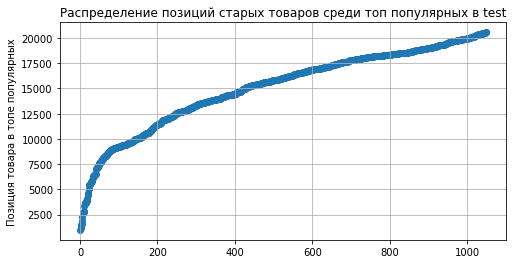

In [23]:
plt.figure(figsize=(8, 4))
plt.scatter(list(range(len(older_20_weeks_in_test))), list(older_20_weeks_items_rates.values()))
plt.title('Распределение позиций старых товаров среди топ популярных в test')
plt.ylabel('Позиция товара в топе популярных')
plt.grid()

Из приведенных выше данных видно, что часть товаров, которые не продавались дольше 20 недель, тем не менее являются достаточно популярными на тесте (но не выше ~топ 5%). Далее их популярность достаточно быстро падает. Тем не менее около 150 товаров из отсеченных находятся в топ 50% теста. 150 товаров - это меньше 1% от всего теста. При этом мы отсекли порядка 44 000 точно неинтересных товаров и только 1000 потенциально интересных

**2. Непопулярные категории**

Определение неинтересных категорий оценим при помощи подсчета количества уникальных пользователей, покупающих товары по категориям. Делаем это из соображений, что нам необходимо будет делать рекомендации для клиентов => если мало клиентов покупают товары этих категорий, значит, мы можем их рекомендовать только малому количеству пользователей, а клиентам, которые и так покупают товары из редких категорий рекомендовать их бессмысленно (они и так покупают).

In [24]:
train_categories = pd.merge(data_train[['item_id', 'user_id']], 
                            item_features[['item_id', 'sub_commodity_desc']], how='left')

In [25]:
nunique_users = train_categories['user_id'].nunique()

categories_popularity = train_categories.groupby('sub_commodity_desc')['user_id'].nunique().reset_index()
categories_popularity['user_id'] = categories_popularity['user_id'] / nunique_users
categories_popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)

nunique_categories = categories_popularity['sub_commodity_desc'].nunique()

In [26]:
print(f'Всего в тренировочном датасете {nunique_users} уникальных покупателей')
print(f'Всего в тренировочном датасете представлено {nunique_categories} категорий')

Всего в тренировочном датасете 2499 уникальных покупателей
Всего в тренировочном датасете представлено 2355 категорий


Будем считать категорию непопулярной если ее покупают меньше 4% (около 100) покупателей

In [27]:
categories_popularity = categories_popularity.sort_values(by=['share_unique_users']).reset_index(drop=True)
categories_popularity.head()

,sub_commodity_desc,share_unique_users
0,*ATH ACCES:TOWEL BARS/SOAP D,0.0004
1,MARINATED BEEF,0.0004
2,BEDDINGS BLANKETS,0.0004
3,BEEF,0.0004
4,MAGAZINE SUBSCRIPTIONS,0.0004


In [28]:
not_popular_categories = \
    categories_popularity.loc[categories_popularity['share_unique_users'] < 0.04, 'sub_commodity_desc'].tolist()

# npc - not popular category
nunique_items_in_npc = \
    train_categories.loc[train_categories['sub_commodity_desc'].isin(not_popular_categories), 'item_id'].nunique()
unique_items_in_npc = \
    train_categories.loc[train_categories['sub_commodity_desc'].isin(not_popular_categories), 'item_id'].unique()

print(f'Отсеиваем {len(not_popular_categories)} непопулярных категорий, в которых суммарно содержится '\
      f'{nunique_items_in_npc} товаров')

Отсеиваем 1281 непопулярных категорий, в которых суммарно содержится 12767 товаров


In [29]:
additional_filtered_after_npc = set(unique_items_in_npc).difference(set(older_20_weeks_only))
npc_filtered_in_test = additional_filtered_after_npc.intersection(set(top_test))

print(f'Этот метод дополнительно отфильтровывает {len(additional_filtered_after_npc)} товаров,'\
     f' из которых {len(npc_filtered_in_test)} присутствуют в валидационной выборке')

Этот метод дополнительно отфильтровывает 5387 товаров, из которых 1015 присутствуют в валидационной выборке


In [30]:
npc_rates = rate_filtered_items_on_test(npc_filtered_in_test, top_test)

print(f'топ-5 отфильтрованных по непопулярным категориям товаров находятся в тесте на позициях {list(npc_rates.values())[:5]}')

топ-5 отфильтрованных по непопулярным категориям товаров находятся в тесте на позициях [295, 384, 853, 888, 985]


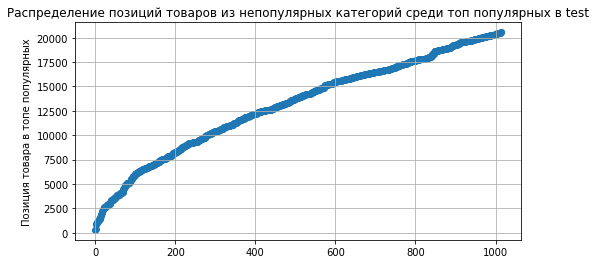

In [31]:
plt.figure(figsize=(8, 4))
plt.scatter(list(range(len(npc_filtered_in_test))), list(npc_rates.values()))
plt.title('Распределение позиций товаров из непопулярных категорий среди топ популярных в test')
plt.ylabel('Позиция товара в топе популярных')
plt.grid()

Из анализа выше видно, что, отбрасывая непопулярные категории, в которых делают покупки менее 4% клиентов  (~100 человек), мы дополнительно к фильтру по неделям отбрасываем 5400 товаров, при этом 1000 из которых ( ~5% от теста) являются потенциально интересными и около 100 из них относительно популярны на тесте (выше топ-25%)

**3.1 Непопулярные товары**

Фильтрацию проведем по аналогии с непопулярными категориями, но порог пользователей поставим в 0.1% (менее 3 человек, фильтр достаточно мощный, поэтому такое значение)

In [32]:
items_popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index()
items_popularity['user_id'] = items_popularity['user_id'] / data_train['user_id'].nunique()
items_popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
items_popularity = items_popularity.sort_values(by=['share_unique_users']).reset_index(drop=True)
items_popularity.head()

,item_id,share_unique_users
0,1403159,0.0004
1,2205386,0.0004
2,2205746,0.0004
3,2205805,0.0004
4,2207141,0.0004


In [33]:
not_popular_items = \
    items_popularity.loc[items_popularity['share_unique_users'] <= 0.001, 'item_id']

# npi - not popular items
nunique_npi = not_popular_items.nunique()

print(f'Отсеиваем {nunique_npi} товаров')

Отсеиваем 45699 товаров


Интересное наблюдение: около 50% всех товаров покупают менее 0.1% всех покупателей (в нашем случае 0.1% - это около 3 человек)<br>
Кажется, это самый мощный фильтр. Узнаем, какое количество товаров отфильтровывается дополнительно к уже отфильтрованным, и насколько они популярны на валидационной выборке

In [34]:
npi_in_test = set(not_popular_items.unique()).intersection(set(top_test))
npi_rates = rate_filtered_items_on_test(npi_in_test, top_test)

print(f'Всего в тренировочном датасете непопулярных товаров: {nunique_npi}')
print(f'{len(npi_in_test)} из них находятся в тесте')
print(f'Топ-5 по популярности непопулярных на train товаров находятся в data_val на позициях {list(npi_rates.values())[:5]}')

Всего в тренировочном датасете непопулярных товаров: 45699
1667 из них находятся в тесте
Топ-5 по популярности непопулярных на train товаров находятся в data_val на позициях [7, 600, 756, 853, 864]


In [35]:
already_filtered = set(older_20_weeks_only).union(set(additional_filtered_after_npc))
additional_filtered_after_npi = set(not_popular_items.unique()).difference(already_filtered)

print(f'Дополнительно отфильтровано {len(additional_filtered_after_npi)}')

Дополнительно отфильтровано 10386


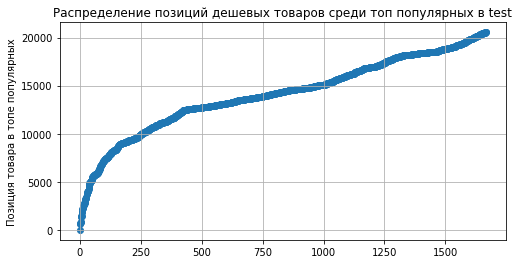

In [36]:
plt.figure(figsize=(8, 4))
plt.scatter(list(range(len(npi_in_test))), list(npi_rates.values()))
plt.title('Распределение позиций дешевых товаров среди топ популярных в test')
plt.ylabel('Позиция товара в топе популярных')
plt.grid()

In [37]:
list(npi_rates.values())[250]

9930

Как видно из данных выше, то, что товар являлся непопулярным на протяжении некоторого времени, совершенно не означает, что он продолжит быть непопулярным. Около 250 таких непопулярных товаров в тренировочной выборке попадают выше топ-25% на тесте. Вероятно, сказывается сезонность или другие факторы.

**3.2 Слишком популярные товары (товары которые покупают более 50% полкупателей)**

Нет смысла рекомендовать, если эти товары и так покупают большое количество человек

In [38]:
too_popular_items = items_popularity.loc[items_popularity['share_unique_users'] >= 0.5, 'item_id']

# tpi - too popular items
nunique_tpi = too_popular_items.nunique()

print(f'Отсеиваем {nunique_tpi} товаров')

Отсеиваем 9 товаров


In [39]:
tpi_in_test = set(too_popular_items.unique()).intersection(set(top_test))
tpi_rates = rate_filtered_items_on_test(tpi_in_test, top_test)

print(f'Всего в тренировочном датасете популярных товаров: {nunique_tpi}')
print(f'{len(tpi_in_test)} из них находятся в тесте')
print(f'Топ-5 по популярности популярных на train товаров находятся в data_val на позициях {list(tpi_rates.values())[:5]}')

Всего в тренировочном датасете популярных товаров: 9
9 из них находятся в тесте
Топ-5 по популярности популярных на train товаров находятся в data_val на позициях [0, 9, 10, 11, 13]


In [40]:
already_filtered = set(already_filtered).union(set(additional_filtered_after_npi))
additional_filtered_after_tpi = set(too_popular_items.unique()).difference(already_filtered)

print(f'Дополнительно отфильтровано {len(additional_filtered_after_tpi)}')

Дополнительно отфильтровано 9


Слабый, тем не менее, на мой взгляд, необходимый фильтр. Популярные товары на тренировочной выборке также достаточно популярны и на тесте.

**4.1 Товары дешевле 1 доллара (бизнес-ограничение)**

Сколько товаров стоят дешевле 1 доллара? Какой это процент от валидационной выборки? Насколько они там популярны

In [41]:
df_prices = data_train.groupby('item_id')[['quantity', 'sales_value']].sum()
df_prices['price'] = df_prices.apply(lambda item: 
                                     item['sales_value'] / item['quantity']
                                     if item['quantity'] else 0, axis=1
                                    )
df_prices.drop(columns=['quantity', 'sales_value'], inplace=True)
df_prices.reset_index(inplace=True)

In [42]:
df_prices.head()

,item_id,price
0,25671,3.49
1,26081,0.99
2,26093,1.59
3,26190,1.54
4,26355,0.99


In [43]:
cheap_items = df_prices.loc[df_prices['price'] < 1, 'item_id'].unique().tolist()
cheap_items_in_test = set(cheap_items).intersection(set(top_test))
cheap_items_rates = rate_filtered_items_on_test(cheap_items_in_test, top_test)

print(f'Всего в тренировочном датасете товаров с ценой менее 1$: {len(cheap_items)}')
print(f'{len(cheap_items_in_test)} из них находятся в тесте')
print(f'Топ-5 по популярности дешевых товаров находятся на позициях {list(cheap_items_rates.values())[:5]}')

Всего в тренировочном датасете товаров с ценой менее 1$: 9897
2383 из них находятся в тесте
Топ-5 по популярности дешевых товаров находятся на позициях [0, 1, 2, 3, 4]


In [44]:
already_filtered = already_filtered.union(set(additional_filtered_after_tpi))
additional_filtered_after_cheap_items = set(cheap_items).difference(set(already_filtered))

print(f'Дополнительно отфильтровано {len(additional_filtered_after_cheap_items)}')

Дополнительно отфильтровано 3161


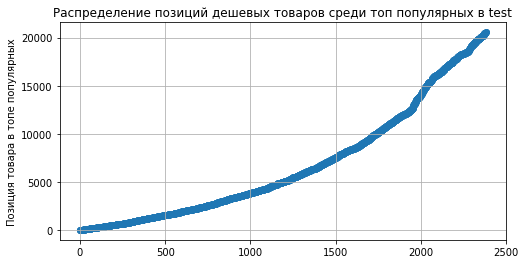

In [45]:
plt.figure(figsize=(8, 4))
plt.scatter(list(range(len(cheap_items_in_test))), list(cheap_items_rates.values()))
plt.title('Распределение позиций дешевых товаров среди топ популярных в test')
plt.ylabel('Позиция товара в топе популярных')
plt.grid()

Видно, что дешевые товары крайне популярны. Из 2500 дешевых товаров, которые можно встретить в тесте, примерно 1250 находятся выше топ-25%. Кроме того, данный фильтр отсекает дополнительно 3200 товаров.

**4.2 Слишком дорогие товары (дороже 20 долларов)**

In [46]:
already_filtered = already_filtered.union(set(additional_filtered_after_cheap_items))

In [47]:
expensive_items = df_prices.loc[df_prices['price'] > 20, 'item_id'].unique()
expensive_items_in_test = set(expensive_items).intersection(set(top_test))
expensive_items_rates = rate_filtered_items_on_test(expensive_items_in_test, top_test)
additional_filtered_after_exp_items = set(expensive_items).difference(already_filtered)

print(f'Всего в тренировочном датасете товаров с ценой более 20$: {len(expensive_items)}')
print(f'{len(expensive_items_in_test)} из них находятся в тесте')
print(f'Дополнительно отфильтровано {len(additional_filtered_after_exp_items)}')
print(f'Топ-5 по популярности дорогих товаров находятся на позициях {list(expensive_items_rates.values())[:5]}')

Всего в тренировочном датасете товаров с ценой более 20$: 956
81 из них находятся в тесте
Дополнительно отфильтровано 126
Топ-5 по популярности дорогих товаров находятся на позициях [3348, 3401, 5177, 6441, 6561]


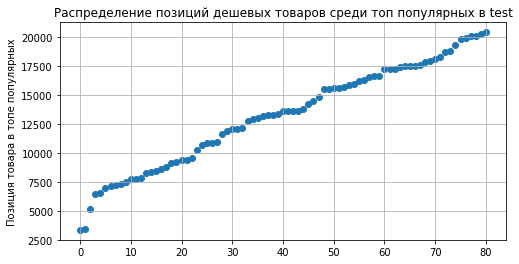

In [48]:
plt.figure(figsize=(8, 4))
plt.scatter(list(range(len(expensive_items_in_test))), list(expensive_items_rates.values()))
plt.title('Распределение позиций дешевых товаров среди топ популярных в test')
plt.ylabel('Позиция товара в топе популярных')
plt.grid()

Дорогие товары слабо представлены в тесте и не являются особо популярными

**5. Сколько новых товаров покупают юзеры по сравнению с предыдущими периодами**

In [49]:
all_train_users = data_train['user_id'].unique()

In [50]:
new_items_percents = []
total_nitems = []
for user in all_train_users:
    train_user_items = data_train.loc[data_train['user_id'] == user, 'item_id'].unique().tolist()
    test_user_items = data_val.loc[data_val['user_id'] == user, 'item_id'].unique().tolist()
    new_items = set(test_user_items).difference(set(train_user_items))
    all_items = set(test_user_items).union(set(train_user_items))
    total_nitems.append(len(all_items))
    new_items_percent = len(new_items) / len(all_items)
    new_items_percents.append(new_items_percent)
    
df_new_items = pd.DataFrame(list(zip(all_train_users, total_nitems, new_items_percents)), 
                            columns=['user_id', 'n_items', 'new_items_percent'])

In [51]:
df_new_items.head()

,user_id,n_items,new_items_percent
0,2375,437,0.013730
1,1364,596,0.053691
2,1130,1403,0.028510
3,1173,186,0.000000
4,98,631,0.030111


In [52]:
df_new_items.loc[df_new_items['new_items_percent'] == 0].shape[0] / df_new_items.shape[0]  

0.2609043617446979

In [53]:
df_new_items.loc[df_new_items['new_items_percent'] > 0.1].shape[0] / df_new_items.shape[0]

0.060024009603841535

Около 25% пользователей вообще не покупали новые товары на валидационной выборке. Также более 10% новых товаров попробовали всего 6% покупателей и около 68% купили в новом периоде до 10% новых для себя товаров

**6. Сколько товаров остается после фильтрации, сколько из них присутствуют в тесте, на каких позициях они находятся по популярности**

In [54]:
total_filtered = already_filtered.union(additional_filtered_after_exp_items)
all_items = data_train['item_id'].unique()
items_after_filters = set(all_items).difference(total_filtered)
items_after_filters_in_test = items_after_filters.intersection(set(top_test))
items_after_filters_recall = len(items_after_filters_in_test) / len(top_test)

print(f'Итого предфильтром отфильтровано {len(total_filtered)} товаров из {len(all_items)}')
print(f'Из них {len(items_after_filters_in_test)} товаров содержится в тестовой выборке')
print(f'Recall составляет {items_after_filters_recall}')

Итого предфильтром отфильтровано 61815 товаров из 87335
Из них 14047 товаров содержится в тестовой выборке
Recall составляет 0.6830537320690494


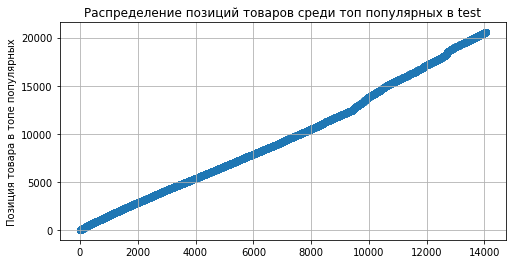

In [55]:
items_after_filters_rates = rate_filtered_items_on_test(items_after_filters_in_test, top_test)

plt.figure(figsize=(8, 4))
plt.scatter(list(range(len(items_after_filters_in_test))), list(items_after_filters_rates.values()))
plt.title('Распределение позиций товаров среди топ популярных в test')
plt.ylabel('Позиция товара в топе популярных')
plt.grid()

In [56]:
print(f'Топ-5 по популярности товаров после фильтрации находятся на позициях {list(items_after_filters_rates.values())[:5]}')

Топ-5 по популярности товаров после фильтрации находятся на позициях [15, 17, 18, 20, 22]


Итого по результатам фильтрации: оставлено 25 000 из 88 000<br>
14 000 являются потенциально актуальными, при этом они составляют около 68% от всего тестового датасета<br>
Таким образом доля потенциально интересных товаров среди оставленных после фильтрации составляет 56%<br>
Самым мощным фильтром является фильтр непопулярных товаров. Незначительно увеличивая порог, можно значительно увеличить количество отфильтрованных товаров

**Предфильтрация**

In [57]:
data_train_prefiltered = prefilter_items(data_train, item_features, take_n_popular=5000)

### Построение моделей

Формируем датасет с покупками юзеров

In [58]:
target_df = data_val.groupby('user_id')['item_id'].unique().reset_index()
target_df.columns=['user_id', 'actual']
target_df.head(2)

,user_id,actual
0,1,"[883616, 917704, 931860, 961554, 995242, 10020..."
1,6,"[909479, 7431990, 6553035, 12263667, 13382461,..."


**1. Подготовка к оценке качества моделей**

Я модифицировал класс MainRecommender, чтобы было удобнее подбирать параметры. Также добавил некоторые функции в utils и metrics для удобства (дополнительно представлены ниже)
* Реализовал метод get_all_users_recomendations - надстройка над get_recomendations, позволяющая выбрать метод и делать рекомендации сразу для списка юзеров
* Добавил возможность делать рекомендации новых товаров и вспомогательные функции для пересчета параметров и повторного обучения моделей в случае изменения user_item матрицы (например, изменения схемы расчета весов).
* По каким-то причинам у меня отказался работать own_recommender (возвращал пустые списки, которые просто заменялись на топ покупок по всему датасету). Реализовал get_custom_own_recommendations на основе top_purchases
* Добавил в имеющиеся методы параметры filter_items и filter_department, а также дописал метод choose_from_different_departments и реализовал логику для обязательного выбора товаров из разных категорий


In [59]:
def create_prices_df(train_data):
    """Функция для формирования датасета с ценами товаров
    Input
    -----
    train_data: pd.Dataframe со столбцами 'sales_value' и 'quantity'
    
    Return
    ------
    df_prices: pd.Dataframe c индексом 'item_id' и столбцом 'prices' 
    """
    assert all(col in train_data.columns for col in ['quantity', 'sales_value']),\
                    "Incorrect input. Columns 'quantity' и 'sales_value' are abscent"
    
    df_prices = train_data.groupby('item_id')[['quantity', 'sales_value']].sum()
    df_prices['price'] = df_prices.apply(lambda item: 
                                         item['sales_value'] / item['quantity']
                                         if item['quantity'] else 0, axis=1
                                        )
    df_prices.drop(columns=['quantity', 'sales_value'], inplace=True)
    
    return df_prices

In [60]:
def get_prices(recommended_list, df_prices):
    """Функция возвращает цены товаров для последующего использования в money_precision
    
    Input
    -----
    recommended_list: list или np.array с item_id рекомендуемых товаров
    df_prices: pd.Dataframe c индексом 'item_id' и столбцом 'prices'
    
    Return
    ------
    prices_recommended: list с ценами рекомендуемых товаров
    """
    assert 'item_id' == df_prices.index.name, "Incorrect input. Index shoud be named as 'item_id'"
    assert 'price' in df_prices.columns, "Incorrect input. Column 'price' is abscent"
    
    prices_recommended = []
    
    for item_id in recommended_list:
        price = df_prices.loc[df_prices.index == item_id, 'price'].values
        prices_recommended.extend(price)
        
    return prices_recommended

In [61]:
def mean_money_precision_at_k(recommended_array, bought_array, df_prices, k=5):
    """Функция для подсчета метрики money_precision по всем юзерам
    
    Input
    -----
    recommended_array: list, содержащий списки рекомендованных товаров
    bought_array: list, содержащий списки купленных товаров
    df_prices: pd.Dataframe c индексом 'item_id' и столбцом 'prices'
    
    Return
    ------
    mean_money_precision_at_k: float, среднее значение метрики по всем юзерам
    """
    
    assert len(recommended_array) == len(bought_array), 'Mismatched dimensions for recommended and bought series'
    
    recommended_array = np.array(recommended_array)
    bought_array = np.array(bought_array)
    
    recommended_prices_array = list(map((lambda x: get_prices(x, df_prices)), recommended_array))
    
    money_precision_list = [money_precision_at_k(recs, bought, prices, k=k)
                           for recs, bought, prices in zip(recommended_array, bought_array, recommended_prices_array)]
    
    mean_money_precision_at_k = np.mean(money_precision_list)
    
    return mean_money_precision_at_k

In [62]:
df_prices = create_prices_df(data_train)

**2. Подбор параметров**

**Как зависит целевая метрика от значений prefilter для модели als**

In [63]:
# Длительный поиск по небольшой сетке. На этапе формирования user_item матрицы везде были взяты топ-5000 товаров. 
# По результатам поиска, лучшими оказались параметры 
# top_not_popular = 0.001, n_weeks_back = 40, n_department = 0.01 (mean_money_precision_at_5 = 0.145)
# Отмечу, что на этапе анализа, разумными казались другие значения

if 0:   
    metric_values = {}
    i = 0

    for top_not_popular in [0.001, 0.0005]:
        for n_weeks_back in [20, 40, 60]:
            for n_department in [0.01, 0.04]:
                data_train_prefiltered = prefilter_items(data_train, item_features,
                                                         filters={'top_popular': 0.5, 
                                                                  'top_notpopular': top_not_popular,
                                                                  'cheaper_than': 1,
                                                                  'more_expensive_than': 20,
                                                                  'last_purchase_n_weeks_back': n_weeks_back,
                                                                  'department_filter': n_department
                                                                 })

                recommender = MainRecommender(data_train_prefiltered)

                recommendations = recommender.get_all_users_recommendations(method='als', 
                                                                           users=target_df['user_id'])
                metric = mean_money_precision_at_k(recommendations, target_df['actual'], df_prices)

                parameters = (top_not_popular, n_weeks_back, n_department)
                metric_values[parameters] = metric

                i += 1
                print(f'Iteration N{i}')

    metric_values = {k: v for k, v in sorted(metric_values.items(), key=lambda item: item[1])}

**Зависимость метрики от параметров обучения модели als**

In [64]:
# Достаточно долгий подбор параметров ALS. Лучшими оказались n_factors=30, iterations=80. 
# Эти параметры, скорее всего, не явяляются глобально-оптимальными, но мощностей запустить что-то более масштабное не хватает.
if 0: 
    all_models = {}
    i = 0

    recommender = MainRecommender(data_train_prefiltered, 
                                  weighting=False)

    for n_factors in range(10, 60, 10):
        for iterations in range(20, 120, 20):
                recommender.als_model = recommender.fit_als(recommender.user_item_matrix, 
                                                            n_factors=n_factors,
                                                            iterations=iterations,
                                                           )
                recommendations = recommender.get_all_users_recommendations(method='als', 
                                                                           users=result_df['user_id'])
                metric = mean_money_precision_at_k(recommendations, result_df['actual'], df_prices)

                params = (n_factors, iterations)
                all_models[params] = metric

                i += 1

                if i % 10 == 0:
                    print(f'Iteration N {i}')

    all_models = {k: v for k, v in sorted(all_models.items(), key=lambda item: item[1])}

**Зависимость метрики от выбора топ-n товаров и взвешивания для рекомендаций als**

In [66]:
# Долгий поиск по выбору параметров take_n_popular и weighting
# Лучшую метрику дали take_n_popular = 8000 без взвешивания (mean_money_precision = 0.146)
if 0:
    metric_values = {}
    i = 0

    for top_n in range(2000, 11000, 1000):
        for weighting in [False, 'bm25', 'tfidf']:
            data_train_prefiltered = prefilter_items(data_train, item_features, take_n_popular=top_n,
                                         filters={'top_popular': 0.5, 
                                                  'top_notpopular': 0.001,
                                                  'cheaper_than': 1,
                                                  'more_expensive_than': 20,
                                                  'last_purchase_n_weeks_back': 40,
                                                  'department_filter': 0.01
                                                 })
            
            recommender = MainRecommender(data_train_prefiltered, weighting=weighting)
            recommendations = recommender.get_all_users_recommendations(method='als', 
                                                                       users=target_df['user_id'])
            metric = mean_money_precision_at_k(recommendations, target_df['actual'], df_prices)

            params = (top_n, weighting)
            metric_values[params] = metric

            i += 1
            if i % 2 == 0:
                print(f'Iteration N {i}')
                                                                    

**3. own_recommender**

По бизнес ограничениям обязательно необходимо рекомендовать 2 новых товара. Значит, own_recommender проверяем на money_precision_at_3

In [67]:
recommender = MainRecommender(data_train_prefiltered, take_n_popular=8000)
own_recs = recommender.get_all_users_recommendations(method='custom_own',
                                                    users=target_df['user_id'],
                                                    N=3
                                                   )
metric = mean_money_precision_at_k(own_recs, target_df['actual'], df_prices)
print(metric)

0.34442239389986423


**Что было протестировано (не вошло в ноутбук):**
* пробовал менять веса в юзер-айтем матрице на сумму покупок (sum вместо count) и заменять quantity на sales_value. Эффекта не увидел, хотя, казалось, что 'sales_value' лучше отражает метрику
* пробовал реализовать предсказания методами knn, но они оказались чересчур ресурсоемкими
* настроил взвешивание, но это не дало больших результатов
* пробовал по-разному менять структуру рекомендаций, использовать другие методы, тем не менее побороть порог в 20% не получилось. Двухуровневую модель построить не успел

В финале уже выяснил, что дорогие товары сильно заваливают метрику. Один такой товар по стоимости часто эквивалентен сумме всех остальных товаров. Всвязи с этим, выбрал следующую структуру рекомендаций:

**Финальная структура рекомендаций**

Рекомендации производятся методом get_final_recommendations. После построения рекомендации для каждого юзера, она обязательно тестируется на удовлетворение бизнес-ограничений.
* Сначала рекомендуется дорогой товар: если юзер ранее покупал дорогие товары, то рекомендуется самый популярный у юзера из них, если юзер холодный или у него нет в прошлых покупках дорогих товаров, тогда рекомендуем методом als, либо просто самый популярный дорогой товар
* Далее рекомендуются 2 собственных товара обязательно дороже 2 долларов, чтобы выровнять метрику
* После этого методом als рекомендуются 2 новых товара, которые юзер не покупал ранее, для этих товаров стоит ограничение, что они не должны быть дороже 2 долларов: с ними очень легко промахнуться и качество рекомендаций таких товаров не очень хорошее, поэтомуискуственно снижаю их суммарную стоимость.

**Метрика на валидации**

In [72]:
data = pd.read_csv('./raw_data/retail_train.csv')
item_features = pd.read_csv('./raw_data/product.csv')
user_features = pd.read_csv('./raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [73]:
data_train = data.loc[(data['week_no'] <= data['week_no'].max() - test_size_weeks)]
data_val = data.loc[(data['week_no'] > data['week_no'].max() - test_size_weeks)]

In [74]:
target_df = data_val.groupby('user_id')['item_id'].unique().reset_index()
target_df.columns=['user_id', 'actual']

Запуск с лучшими параметрами, параметры изменены по сравнению с результатами предыдущего анализа (на тот момент там не были учтены бизнес ограничения)

In [75]:
data_train_prefiltered = prefilter_items(data_train, item_features, take_n_popular=12000,
                                         filters={
                                                  'top_notpopular': 0.0005,
                                                  'cheaper_than': 1,
                                                  'more_expensive_than': 20,
                                                  'last_purchase_n_weeks_back': 40
                                                 })


df_prices = create_prices_df(data_train_prefiltered)
recommender = MainRecommender(data_train_prefiltered, weighting='bm25', k=0.0001, b=0.01)
recommender.als_model = recommender.fit_als(recommender.user_item_matrix, n_factors=8, regularization=0.01, 
                                            iterations=10)
recommendations = recommender.get_final_recommendations(target_df['user_id'])

final_recommendations_df = target_df
final_recommendations_df['recommended'] = recommendations

metric = mean_money_precision_at_k(final_recommendations_df['recommended'], 
                                   final_recommendations_df['actual'], df_prices)
print(metric)

0.18824821288978708


**Метрика на паблике**

In [77]:
data_public_train = pd.read_csv('./raw_data/retail_train.csv')
item_features = pd.read_csv('./raw_data/product.csv')
data_public_test = pd.read_csv('./raw_data/retail_test.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [78]:
target_df = data_public_test.groupby('user_id')['item_id'].unique().reset_index()
target_df.columns=['user_id', 'actual']

In [79]:
data_public_train_prefiltered = prefilter_items(data_public_train, item_features, take_n_popular=12000,
                                                filters={'top_notpopular': 0.0005,
                                                         'cheaper_than': 1,
                                                         'more_expensive_than': 20,
                                                         'last_purchase_n_weeks_back': 40
                                                        }
                                               )


df_prices = create_prices_df(data_public_train_prefiltered)
recommender = MainRecommender(data_public_train_prefiltered, weighting='bm25', k=0.0001, b=0.01)
recommender.als_model = recommender.fit_als(recommender.user_item_matrix, n_factors=8, regularization=0.01, 
                                            iterations=10)
recommendations = recommender.get_final_recommendations(target_df['user_id'])

final_recommendations_df = target_df
final_recommendations_df['recommended'] = recommendations

metric = mean_money_precision_at_k(final_recommendations_df['recommended'], 
                                   final_recommendations_df['actual'], df_prices)
print(metric)

0.1872915798074465


In [80]:
to_save_df = final_recommendations_df[['user_id', 'recommended']]
to_save_df.to_csv('results.csv', index=False)